## Part 1

### Loading the datasets
#### 1. Confirmed URL : https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
#### 2. Deaths URL: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv
#### 3. Recovered URL: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv

#### Starting date on all three datasets is 22/01/2020

Steps (Without BeautifulSoup):-
1. Import the CSV 
2. Check if the last column title matches with the last date row in the cleaned dataset.
3. If it matches, don't add it to the dataset. 
4. If it does not match, go back iteratively until it matches and save all of the data.


In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import requests
from bs4 import BeautifulSoup
from datetime import date
today = date.today()

In [148]:
confirmed_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
deaths_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
recovered_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

In [149]:
d1 = today.strftime("%m/%d/%y").replace(' 0', ' ')
if(d1[0] == '0'):
    d1 = d1[1:]
d1

'5/24/20'

### Function to get the number of confirmed cases as a Dataframe

In [150]:
def get_confirmed():
    con_casesnew = pd.read_csv(confirmed_url)
    con_casesnew = con_casesnew.sum(axis=0)
    con_casesnew.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    con_casesnew = pd.DataFrame(con_casesnew)
    con_casesnew.rename(columns={0: "Infected"}, inplace=True)
    return con_casesnew
get_confirmed()

,Infected
1/22/20,555
1/23/20,654
1/24/20,941
1/25/20,1434
1/26/20,2118
...,...
5/19/20,4897492
5/20/20,4996472
5/21/20,5102424
5/22/20,5210817


### Function to get the number of deaths as a Dataframe

In [151]:
def get_deaths():
    deaths_new = pd.read_csv(deaths_url)
    deaths_new = deaths_new.sum(axis=0)
    deaths_new.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    deaths_new = pd.DataFrame(deaths_new)
    deaths_new.rename(columns={0: "Deaths"}, inplace=True)
    return deaths_new
get_deaths()

,Deaths
1/22/20,17
1/23/20,18
1/24/20,26
1/25/20,42
1/26/20,56
...,...
5/19/20,323285
5/20/20,328115
5/21/20,332924
5/22/20,338160


### Function to get the number of recoveries as a Dataframe

In [152]:
def get_recovered():
    rec_new = pd.read_csv(recovered_url)
    rec_new = rec_new.sum(axis=0)
    rec_new.drop(["Country/Region","Lat","Long"], axis=0, inplace=True)
    rec_new = pd.DataFrame(rec_new)
    rec_new.rename(columns={0: "Recovered"}, inplace=True)
    
    return rec_new
get_recovered()

,Recovered
1/22/20,28
1/23/20,30
1/24/20,36
1/25/20,39
1/26/20,52
...,...
5/19/20,1838995
5/20/20,1897466
5/21/20,1948739
5/22/20,2056643


### Scraper

In [153]:
def get_newvals():
    url_wminfo = "https://www.worldometers.info/coronavirus/"
    page = requests.get(url_wminfo)
    soup = BeautifulSoup(page.content, 'html.parser')
    result = soup.find_all("div", {"id":"maincounter-wrap"})
    numbers = []
    for r in result:
        numbers.append(int(r.text.split(':')[-1].replace(',','').replace(' ','')))
    return numbers

In [154]:
numbers = get_newvals()
numbers

[5407378, 344019, 2247930]

## Forecasting Confirmed Cases

In [155]:
df = get_confirmed()
df.tail()

,Infected
5/19/20,4897492
5/20/20,4996472
5/21/20,5102424
5/22/20,5210817
5/23/20,5310362


In [156]:
close_data = df['Infected'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

cclose = close_data

In [157]:
look_back = 2

train_generator = TimeseriesGenerator(cclose, cclose, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [158]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 100
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100
7/7 [==============================] - 1s 104ms/step - loss: 6054749667066.5781
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 6011807647875.8350
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 5963530035152.6279
Epoch 4/100
7/7 [==============================] - 0s 18ms/step - loss: 5921391765355.3721
Epoch 5/100
7/7 [==============================] - 0s 19ms/step - loss: 5874859823927.0742
Epoch 6/100
7/7 [==============================] - 0s 20ms/step - loss: 5833101804108.4629
Epoch 7/100
7/7 [==============================] - 0s 21ms/step - loss: 5776242080769.2891
Epoch 8/100
7/7 [==============================] - 0s 20ms/step - loss: 5723891517797.5537
Epoch 9/100
7/7 [==============================] - 0s 19ms/step - loss: 5676755152956.0996
Epoch 10/100
7/7 [==============================] - 0s 14ms/step - loss: 5633354496456.6943
Epoch 11/100
7/7 [==============================] - 0s 16ms/step - loss: 5573424349307.83

7/7 [==============================] - 0s 6ms/step - loss: 543571502631.7190
Epoch 91/100
7/7 [==============================] - 0s 7ms/step - loss: 497641386768.9339
Epoch 92/100
7/7 [==============================] - 0s 21ms/step - loss: 470422483488.9256
Epoch 93/100
7/7 [==============================] - 0s 19ms/step - loss: 453024624555.4132
Epoch 94/100
7/7 [==============================] - 0s 18ms/step - loss: 413803053439.2397
Epoch 95/100
7/7 [==============================] - 0s 19ms/step - loss: 388992990926.3513
Epoch 96/100
7/7 [==============================] - 0s 20ms/step - loss: 359122657911.4091
Epoch 97/100
7/7 [==============================] - 0s 19ms/step - loss: 342211449840.7686
Epoch 98/100
7/7 [==============================] - 0s 20ms/step - loss: 313063638952.2852
Epoch 99/100
7/7 [==============================] - 0s 20ms/step - loss: 292027305635.9008
Epoch 100/100
7/7 [==============================] - 0s 19ms/step - loss: 271708343661.1157


In [159]:
prediction = model.predict_generator(test_generator)

cclose = cclose.reshape((-1))
close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

In [160]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
num_prediction = 1
forecast = predict(num_prediction, model)
forecast = numbers[0]

In [161]:
forecast

5407378

In [162]:
df.tail()

,Infected
5/19/20,4897492
5/20/20,4996472
5/21/20,5102424
5/22/20,5210817
5/23/20,5310362


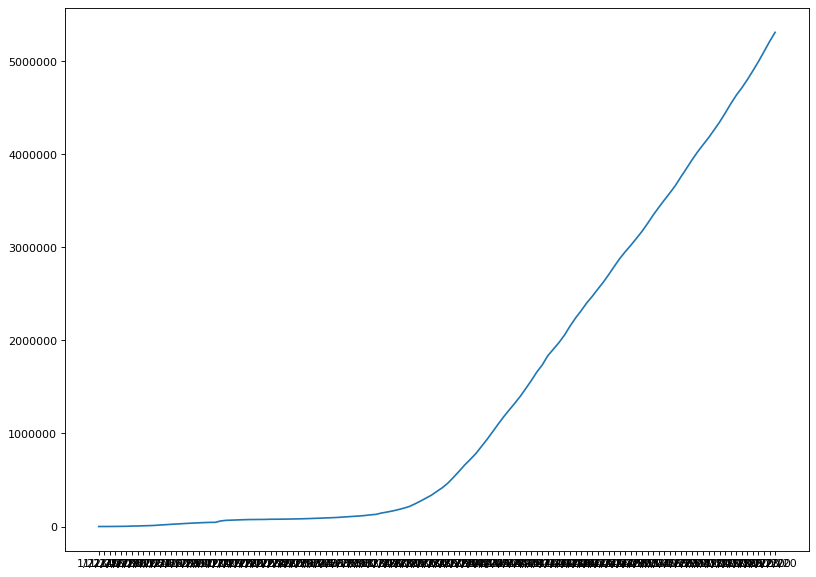

In [163]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df)

In [164]:
df_temp = df
df_temp.loc[d1] = forecast
df_temp

,Infected
1/22/20,555
1/23/20,654
1/24/20,941
1/25/20,1434
1/26/20,2118
...,...
5/20/20,4996472
5/21/20,5102424
5/22/20,5210817
5/23/20,5310362


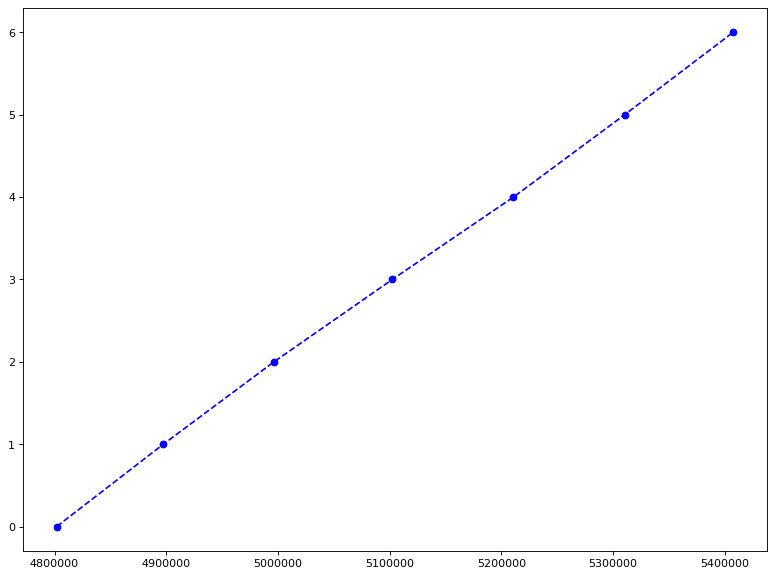

In [165]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12,9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_temp[-7:], range(7), linestyle='--', marker='o', color='b')

## Forecasting Recoveries

In [166]:
df_rec = get_recovered()
df_rec.tail()

,Recovered
5/19/20,1838995
5/20/20,1897466
5/21/20,1948739
5/22/20,2056643
5/23/20,2112185


In [167]:
close_data_rec = df_rec['Recovered'].values
close_data_rec = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data_rec))

close_train_rec = close_data_rec[:split]
close_test_rec = close_data_rec[split:]

cclose_rec = close_data_rec

In [169]:
prediction_rec = model.predict_generator(test_generator_rec)

cclose_rec = cclose_rec.reshape((-1))
close_train_rec = close_train_rec.reshape((-1))
close_test_rec = close_test_rec.reshape((-1))
prediction_rec = prediction_rec.reshape((-1))

In [168]:
look_back = 2

train_generator_rec = TimeseriesGenerator(cclose_rec, cclose_rec, length=look_back, batch_size=20)     
test_generator_rec = TimeseriesGenerator(close_test_rec, close_test_rec, length=look_back, batch_size=1)

In [170]:
close_data_rec = close_data_rec.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data_rec[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
num_prediction = 1
forecast_rec = predict(num_prediction, model)
forecast_rec = numbers[2]

In [171]:
forecast_rec

2247930

In [172]:
df_rec.tail()

,Recovered
5/19/20,1838995
5/20/20,1897466
5/21/20,1948739
5/22/20,2056643
5/23/20,2112185


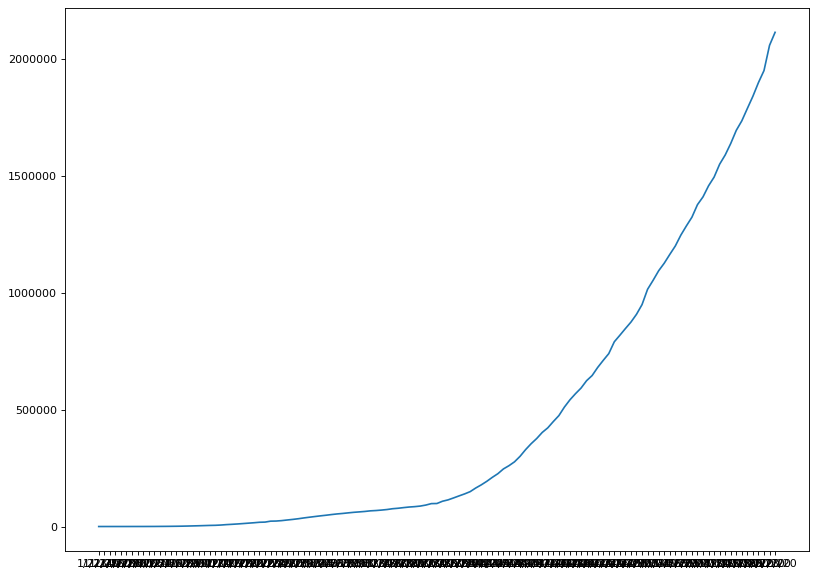

In [173]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_rec)

In [174]:
df_temp_rec = df_rec
df_temp_rec.loc[d1] = forecast_rec
df_temp_rec

,Recovered
1/22/20,28
1/23/20,30
1/24/20,36
1/25/20,39
1/26/20,52
...,...
5/20/20,1897466
5/21/20,1948739
5/22/20,2056643
5/23/20,2112185


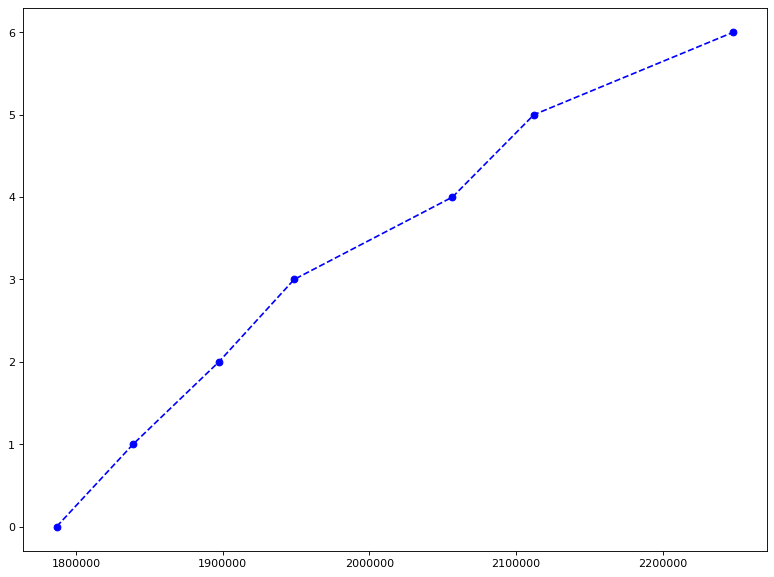

In [175]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12,9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_temp_rec[-7:], range(7), linestyle='--', marker='o', color='b')

## Forecasting Deaths

In [166]:
df_dea = get_deaths()
df_dea.tail()

,Recovered
5/19/20,1838995
5/20/20,1897466
5/21/20,1948739
5/22/20,2056643
5/23/20,2112185


In [167]:
close_data_dea = df_dea['Deaths'].values
close_data_dea = close_data_dea.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data_dea))

close_train_dea = close_data_dea[:split]
close_test_dea = close_data_dea[split:]

cclose_dea = close_data_dea

In [168]:
look_back = 2

train_generator_dea = TimeseriesGenerator(cclose_dea, cclose_dea, length=look_back, batch_size=20)     
test_generator_dea = TimeseriesGenerator(close_test_dea, close_test_dea, length=look_back, batch_size=1)

In [169]:
prediction_dea = model.predict_generator(test_generator_dea)

cclose_dea = cclose_dea.reshape((-1))
close_train_dea = close_train_dea.reshape((-1))
close_test_dea = close_test_dea.reshape((-1))
prediction_dea = prediction_dea.reshape((-1))

In [170]:
close_data_dea = close_data_dea.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data_dea[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
num_prediction = 1
forecast_dea = predict(num_prediction, model)
forecast_dea = numbers[1]

In [171]:
forecast_dea

2247930

In [172]:
df_dea.tail()

,Recovered
5/19/20,1838995
5/20/20,1897466
5/21/20,1948739
5/22/20,2056643
5/23/20,2112185


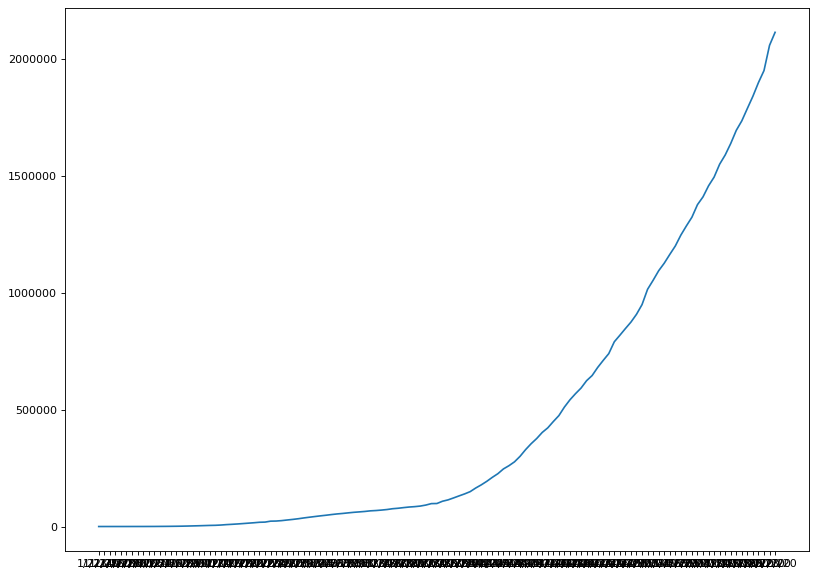

In [173]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_dea)

In [174]:
df_temp_rec = df_rec
df_temp_rec.loc[d1] = forecast_rec
df_temp_rec

,Recovered
1/22/20,28
1/23/20,30
1/24/20,36
1/25/20,39
1/26/20,52
...,...
5/20/20,1897466
5/21/20,1948739
5/22/20,2056643
5/23/20,2112185


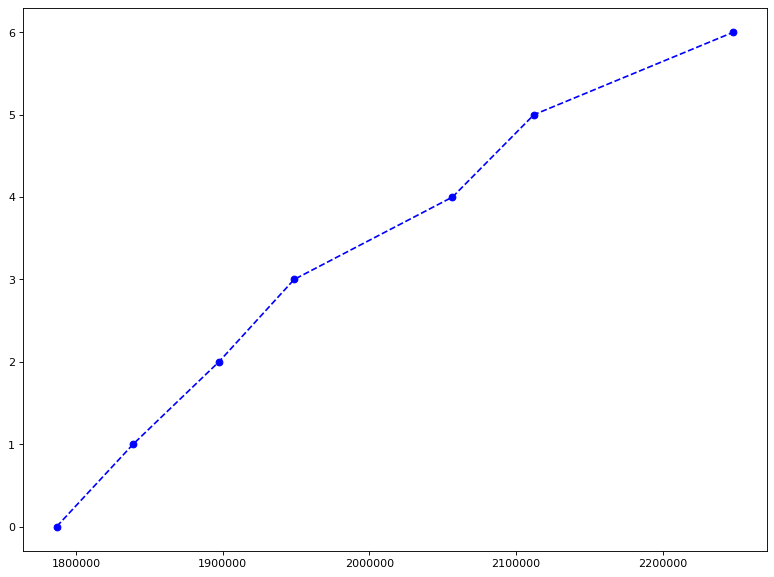

In [175]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12,9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_temp_rec[-7:], range(7), linestyle='--', marker='o', color='b')